### Imports and methods

In [1]:
# Copied from openrandonaut.py

import math
import pandas as pd
from scipy import stats
import numpy as np
import quantumrandom

earth_radius = 6371  # km
one_degree = earth_radius * 2 * math.pi / 360 * 1000  # 1° latitude in meters

def int_to_float(input_integer):

    source_bits = int(math.ceil(math.log(1 + 1, 2)))
    source_size = int(math.ceil(source_bits / float(quantumrandom.INT_BITS)))
    source_max = 2 ** (source_size * quantumrandom.INT_BITS) - 1

    modulos = source_max / 1

    while True:
        num = 0
        for x in range(source_size):
            num <<= quantumrandom.INT_BITS
            num += input_integer

        if num >= modulos:
            return None
        else:
            return num / modulos


def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)


def random_location(start_lat, start_lon, max_radius, random_float_1, random_float_2):
    r = max_radius * random_float_1 ** 0.5
    theta = random_float_2 * 2 * math.pi
    dx = r * math.cos(theta)
    dy = r * math.sin(theta)

    random_lat = start_lat + dy / one_degree
    random_lon = start_lon + dx / (one_degree * math.cos(start_lat * math.pi / 180))

    return random_lat, random_lon

### Load data from qrng

In [2]:
num_points = 4096
numbers = []
if num_points >= 1024:
    for i, x in enumerate(range(int(num_points / 1024))):
        x += 1
        print(
           f"Getting {1024*x} random unsigned 16-bit integers from QRNG...",
           end=" ",
           )
        print(f"({1024*x}/{num_points})", end="\r")
        numbers.extend(
           quantumrandom.get_data(data_type="uint16", array_length=1024, block_size=1)
        )
else:
    numbers.extend(
       quantumrandom.get_data(data_type="uint16", array_length=num_points, block_size=1)
    )

### Main method

In [3]:
def main_generate_location(start_lat, start_lon, radius, num_points, numbers):

    #if num_points % 1024 != 0:
    #    print("ERROR: num_points must be divisible by 1024")
    #    return

    print("\nConverting integers to coordinates...")
    coord_list = []
    # Iterate over numbers from QRNG in pairs and convert them to coordinates
    for v, w in pairwise(numbers):
        v = int_to_float(v)
        w = int_to_float(w)

        longitude, latitude = random_location(start_lat, start_lon, radius, v, w)

        coord_list.append([longitude, latitude])

    # Create DataFrame from list of coordinates
    df = pd.DataFrame(coord_list, columns=["longitude", "latitude"])

    y_data = df.latitude
    x_data = df.longitude

    print("Calculating gaussian kernel density estimate...")
    kernel = stats.gaussian_kde(np.vstack([x_data, y_data]), bw_method="silverman")

    # define grid.
    xmin, xmax = min(x_data), max(x_data)
    ymin, ymax = min(y_data), max(y_data)
    x, y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([x.ravel(), y.ravel()])

    k_pos = kernel(positions)

    max_dense_lon, max_dense_lat = positions.T[np.argmax(k_pos)]

    print(f"KDE cordinates: {max_dense_lat}, {max_dense_lon}")
    return max_dense_lon, max_dense_lat, radius, num_points, x_data, y_data, x, y, positions, k_pos

In [4]:
max_dense_lon, max_dense_lat, radius, num_points, x_data, y_data,  x, y, positions, k_pos = main_generate_location(0, 0, 1000, num_points, numbers)


Converting integers to coordinates...
Calculating gaussian kernel density estimate...
KDE cordinates: 0.0029523789411334683, 0.003180263748090195


### Plot with heatmap

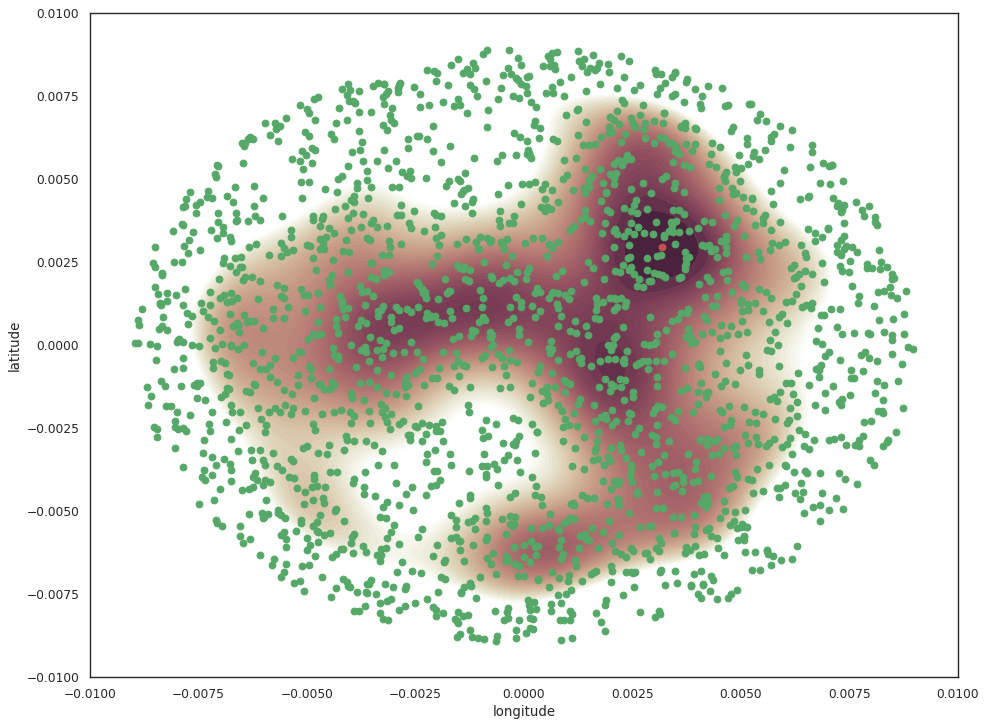

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

sns.set_theme(style="white")

figure(figsize=(14, 11), dpi=80)
cmap = sns.cubehelix_palette(start=0.33, light=1, as_cmap=True)

x,y = x_data, y_data
sns.kdeplot(
        x=x, y=y,
        cmap=cmap, fill=True,
        clip=(-0.01, 0.01), 
        cut=15,
        thresh=0.4, 
        levels=50
    )
plt.scatter(x, y, color="g")
plt.scatter(max_dense_lon, max_dense_lat, color="r")
plt.show()